# Race Studio 3 Data Processing

<div class="alert alert-block alert-success">
<b>TLDR:</b> Scroll to the <a href="#work-with-data" title="Work With Data">Work With Data</a> section at the bottom of this notebook to begin working with the RaceStudio3 data.  Everything above is related to configuration and data processing.
</div>

# Initial Configuration

Run this module before running anything else.

## Install Necessary Python Packages

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Initialize Python Packages

In [2]:
import pint
import pandas as pd
import pint_pandas
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import scipy.io
from typing import Iterable, Optional
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt


from race_analysis.constants import *
from race_analysis.units import u


pint_pandas.PintType.ureg = u
pint_pandas.PintType.ureg.setup_matplotlib()

### Utility Functions

#### Data Manipulation and Exporting Functions

Useful functions that handle exporting data to `.csv` files, converting series to their base-unit values, and more.

In [3]:
from race_analysis.df_utils import *
from race_analysis.utils import *
from race_analysis.time_utils import *

#### Data Exporting Functions
Useful helper functions for exporting data.

In [4]:
from race_analysis.export_data import export_data_to_csv

### Plotting Functions

Helper functions to simplify the data-plotting process.

In [5]:
from race_analysis.plot_data import *
from race_analysis.map_data import *

### Initialize Race Data from Spreadsheet

This code takes formatted race data from a `.csv` file and parses it into [`Pandas Dataframes`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), [`Pint`](https://pint.readthedocs.io/en/stable/) Unit objects, and [`Pint Pandas`](https://pint.readthedocs.io/en/0.18/pint-pandas.html) dataframe extension so that computations can be easily performed on the data.

#### Compute Laps

Since the data exported from RaceStudio3 does not include the lap number or lap-related parameters, the below codeblock uses ML to determine the probable location of the start of the lap (based on the `GPS Latitude` and `GPS Longitude` values and their repetitiveness).  It then initializes a bunch of Lap-specific parameters that would be useful for the analysis.

In [6]:
from race_analysis.laps_data import *

#####################################################################
#### USE THIS FUNCTION TO UPDATE THE DATA FILES WITH LAP NUMBERS ####
#####################################################################
# # # from race_analysis.laps_data import set_lap_num_in_data_csv
# # # set_lap_num_in_data_csv()

#### Set Custom Columns

This is where custom columns and math channels are defined.  The master `RACE_DATA_DF` dataframe includes all race data, including columns for these newly defined channels.

In [7]:
from race_analysis.columns import set_delta

#### Retrieve Commonly Used Column Names

In [8]:
from race_analysis.column_names import *

### Build RaceStudio3 Dataframe

This is the code that initializes the data structure to be used throughout this Jupyter Notebook.

In [9]:
from race_analysis.race import *

# Work with Data

## Define Vehicle Constants

These are the constants and values associated with the car, as well as where said values were sourced.

In [10]:
from race_analysis.constants import *

#### MOTOR SPECIFICATIONS ####
electric_motor_mass = 22 * u.kg             # https://www.electricmotorsport.com/me1616-brushless-65hp-liquid-cooled-ipm-motor-24-120v.html
"""Mass of the ME1616 electric motor"""

electric_power_continuous = 20 * u.kW       # https://www.electricmotorsport.com/me1616-brushless-65hp-liquid-cooled-ipm-motor-24-120v.html
"""Continuous power for the ME1616 electric motor"""
electric_power_peak = 55 * u.kW             # https://www.electricmotorsport.com/me1616-brushless-65hp-liquid-cooled-ipm-motor-24-120v.html
"""Peak power for the ME1616 electric motor"""

electric_stall_torque = 134 * u.N * u.m     # https://www.electricmotorsport.com/me1616-brushless-65hp-liquid-cooled-ipm-motor-24-120v.html
"""Stall torque for the ME1616 electric motor"""
electric_continuous_torque = 55 * u.N * u.m # https://www.miromax.lt/userfiles/6/files/ME%20MAX%201507_1616%20%20AIR_Water%20Cooled%2020kW_55kW_96V_.pdf
"""Continuous torque for the ME1616 electric motor at 250 Amps"""
##############################

#### BASIC CALCULATIONS ####
torque_gas = (POWER_GAS_AT_WHEELS / PEAK_GAS_RPM).to(u.N * u.m)
"""Torque of the gas-powered vehicle"""
TMR_gas = torque_gas / MASS_CAR
"""Torque-Mass ratio of the gas-powered vehicle"""
PMR_gas = POWER_GAS_AT_WHEELS / MASS_CAR
"""Power-Mass ratio of the gas-powered vehicle"""
############################

print(f'PEAK GAS ANGULAR SPEED \t{PEAK_GAS_RPM.to_base_units()}')
print(f'GAS POWER IN WATTS     \t{POWER_GAS_AT_WHEELS.to(u.W)}')
print(f'TORQUE OF GAS MOTOR    \t{torque_gas}')
print(f'TORQUE-MASS RATIO (GAS)\t{TMR_gas}')
print(f'POWER-MASS RATIO (GAS) \t{PMR_gas.to(u.kW / u.kg)}')

avg_power = (.5 * electric_power_continuous + .5 * electric_power_peak)
on_elec_per_lap = 30 * u.sec
num_laps = 25

total_energy = avg_power*on_elec_per_lap*num_laps
print(f'TOTAL ENERGY\t\t{total_energy.to(u.kWh)}')
print(f'AVERAGE POWER\t\t{avg_power}')
operating_voltage = 96 * u.V
print(f'OPERATING AMPERAGE\t{(avg_power/operating_voltage).to(u.amp)}')
print(f'TOTAL AMP HOURS\t\t{(total_energy / operating_voltage).to(u.amp * u.hr)}')

print(f'EV ENERGY PER LAP\t{(total_energy / num_laps).to(u.kWh)}')

battery_mass_density = 55 * u.Wh / u.lb

print(f'BATTERY MASS\t\t{(total_energy / battery_mass_density).to_base_units()}')



max_axle_rpm = 2400 * u.rpm
distance_per_revolution = (2 * RADIUS_WHEEL_BACK * math.pi) / u.revolution
distance_per_minute = max_axle_rpm * distance_per_revolution
print(distance_per_minute.to('mph'))


PEAK GAS ANGULAR SPEED 	1235.6931104119853 radian / second
GAS POWER IN WATTS     	108126.48137942917 watt
TORQUE OF GAS MOTOR    	87.50269825764373 meter * newton
TORQUE-MASS RATIO (GAS)	0.17057056190573827 meter * newton / kilogram
POWER-MASS RATIO (GAS) 	0.21077286818602176 kilowatt / kilogram
TOTAL ENERGY		7.8125 kilowatt_hour
AVERAGE POWER		37.5 kilowatt
OPERATING AMPERAGE	390.625 ampere
TOTAL AMP HOURS		81.38020833333334 ampere * hour
EV ENERGY PER LAP	0.3125 kilowatt_hour
BATTERY MASS		64.43073437500001 kilogram
161.91458200319622 mile_per_hour


## Load in Data

Define the filepath of the data file you are trying to load in, as well as the corresponding `units` dictionary containing that dataset's units values.

> The `units` dictionary is helpful, but not critical due to Pint's builtin unit-handling capabilities.  This is a remnant of an older implementation of some functionality that @HenryAsa hasn't yet removed.

In [11]:
RACE_DATA_FILEPATH = f'{DATA_DIRECTORY}/BETTER_20230831_143833_Blair Hosie_Rush SR 150_Palmer ACW_a_0045.csv'
RACE_DATA_FILES_TO_USE = {
    f'{DATA_DIRECTORY}/BETTER_20230831_143833_Blair Hosie_Rush SR 150_Palmer ACW_a_0045.csv',
    f'{DATA_DIRECTORY}/BETTER_20240127_1528_Blair Hosie_Rush SR 0003_PODIUM_Generic testing_a_1215.csv'
}
UNITS: dict[str, str] = {}

RACE_DATA_DF = load_race(race_data_filepath=RACE_DATA_FILEPATH, units=UNITS)
"""All Race Data stored in a Pandas Dataframe with Pint Units built-in to handle unit conversions and unit operations"""

'All Race Data stored in a Pandas Dataframe with Pint Units built-in to handle unit conversions and unit operations'

## Generate Plots for Data

In [12]:
# speed_during_coast = pd.Series(RACE_DATA_DF['GPS Speed'] * RACE_DATA_DF['GPS CST On'], name='Speed During Coasting')
# plot_data(RACE_DATA_DF['Time'], f'Time ({UNITS["Time"]})', speed_during_coast.pint.to('miles/hr'), 'Vehicle Speed During Coasting (miles/hr)')

# acceleration_during_coast = pd.Series(RACE_DATA_DF['GPS Speed'].diff().fillna(0) * RACE_DATA_DF['GPS CST On'] / RACE_DATA_DF['dT'].replace(0, np.nan), name='Acceleration During Coasting')
# plot_data(RACE_DATA_DF['Time'], f'Time ({UNITS["Time"]})', acceleration_during_coast.pint.to('m/(s^2)'), 'Acceleration During Coasting (m/(s^2))')

/var/folders/_z/b5v6x7_j5y54s3q7pqgbnzc40000gn/T/ipykernel_86598/1056481172.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  1 * df.groupby(COL_LAP_NUM).apply(


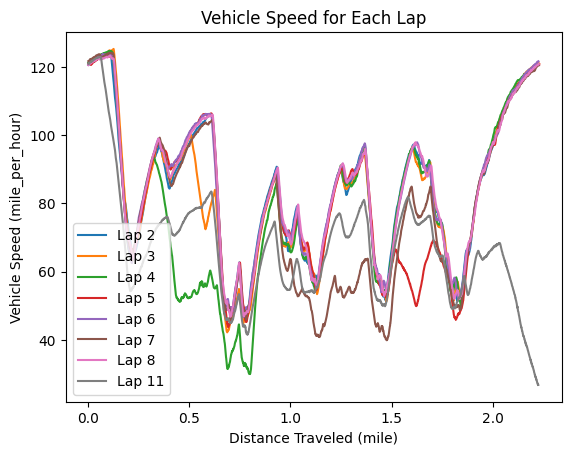

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


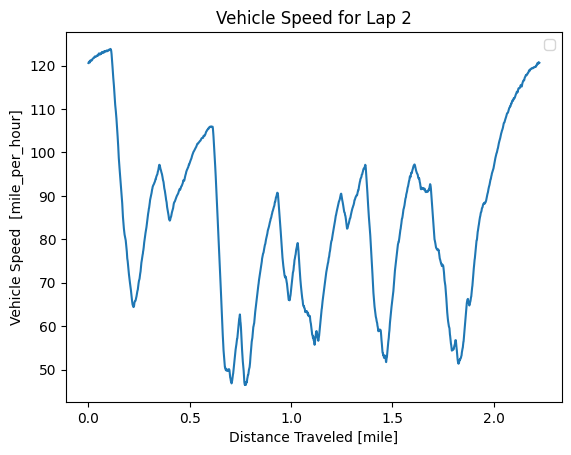

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


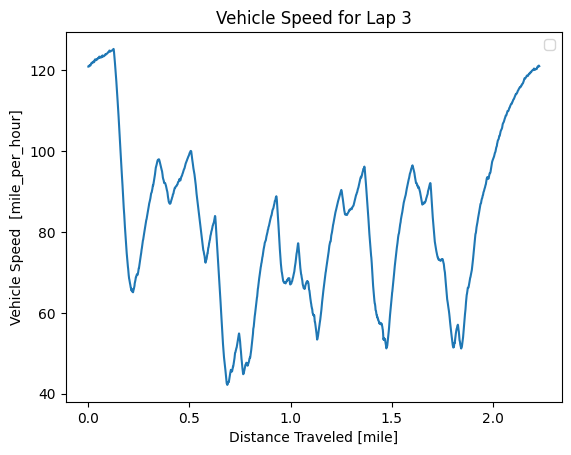

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


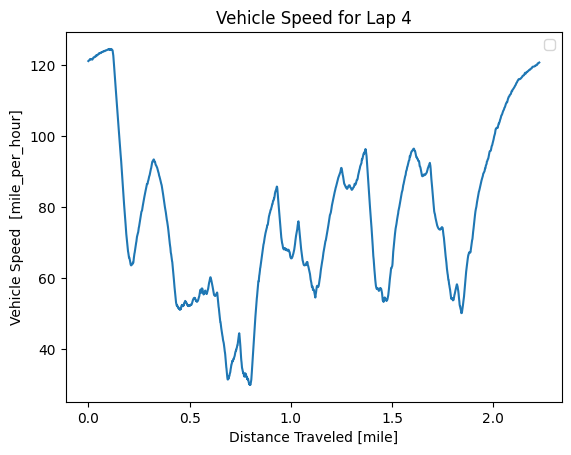

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


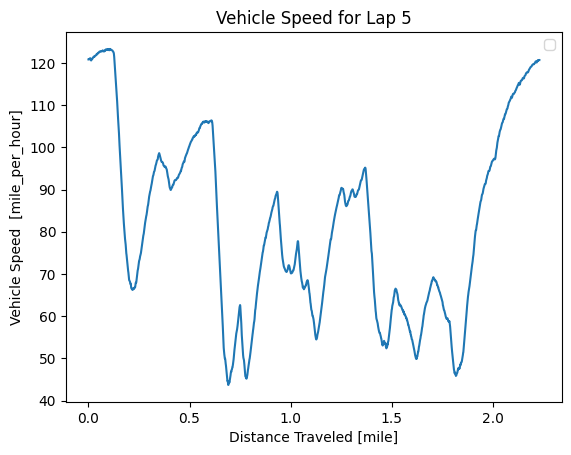

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


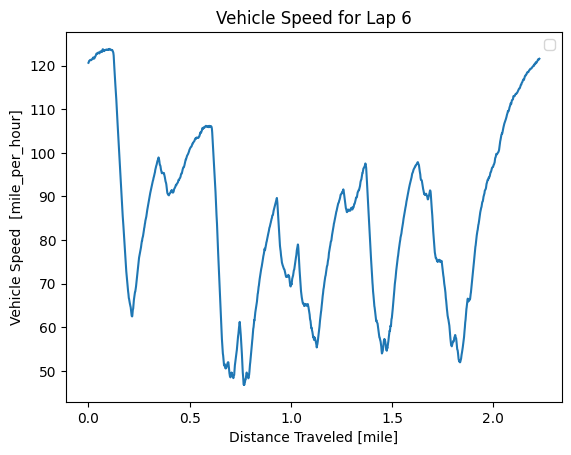

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


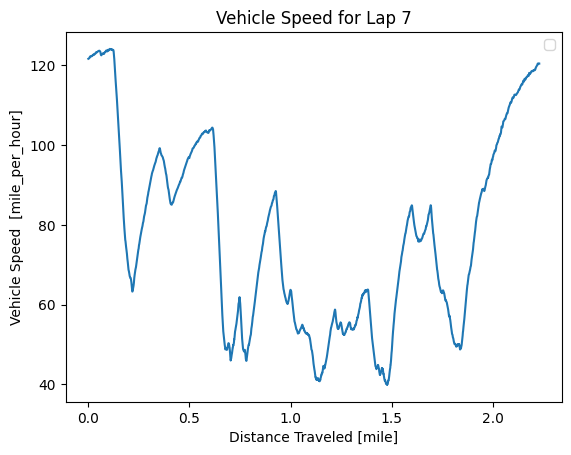

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


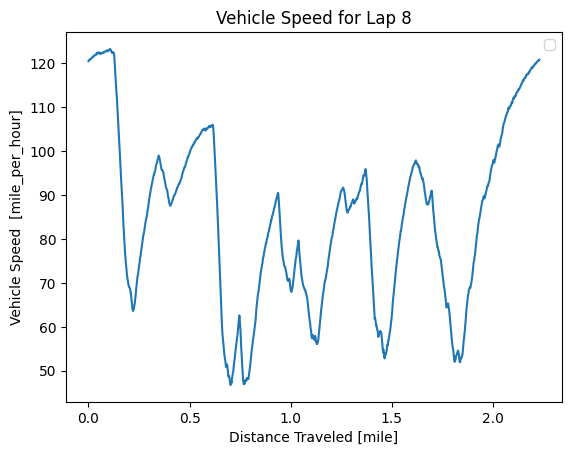

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


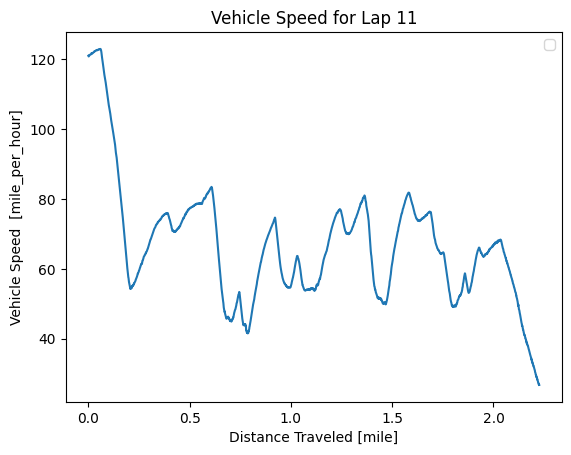

/var/folders/_z/b5v6x7_j5y54s3q7pqgbnzc40000gn/T/ipykernel_86598/1056481172.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  1 * df.groupby(COL_LAP_NUM).apply(


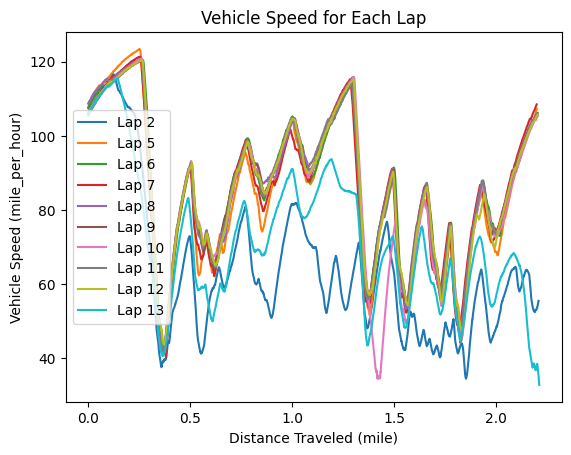

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


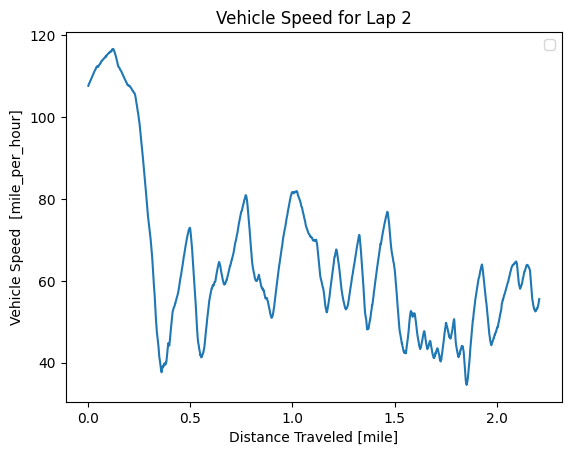

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


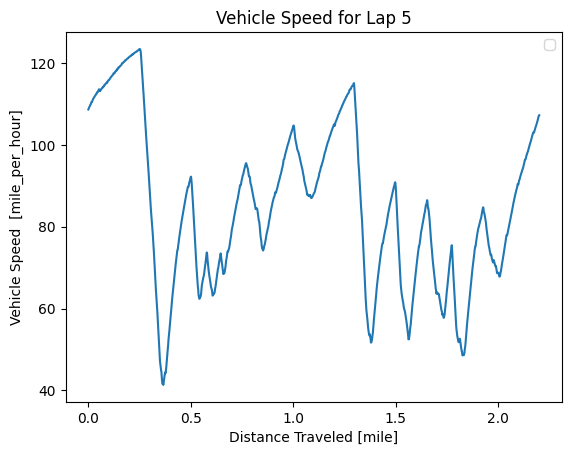

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


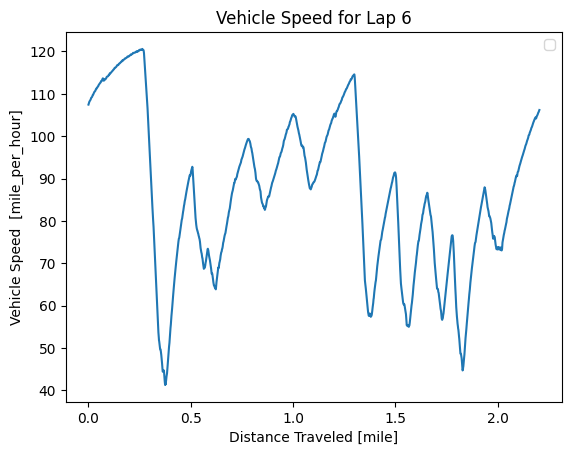

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


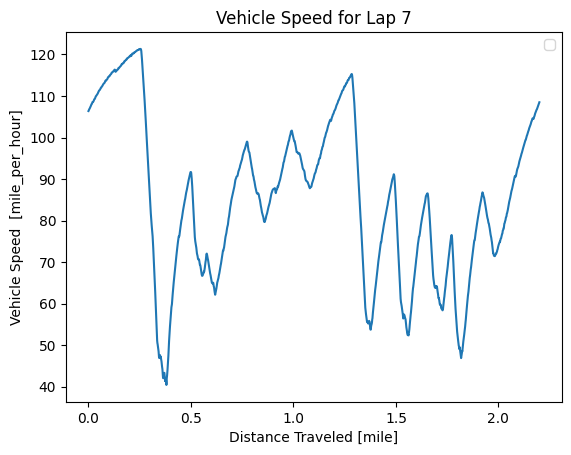

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


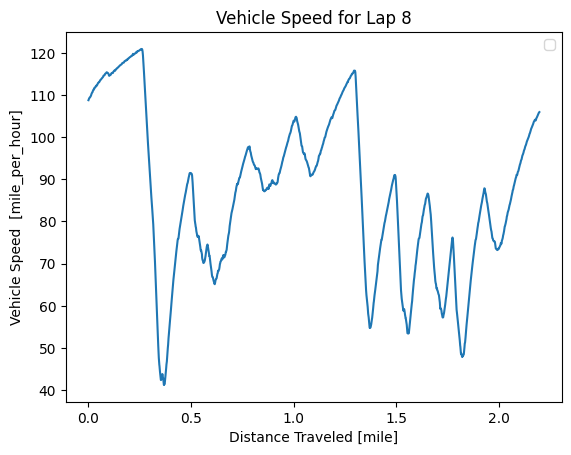

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


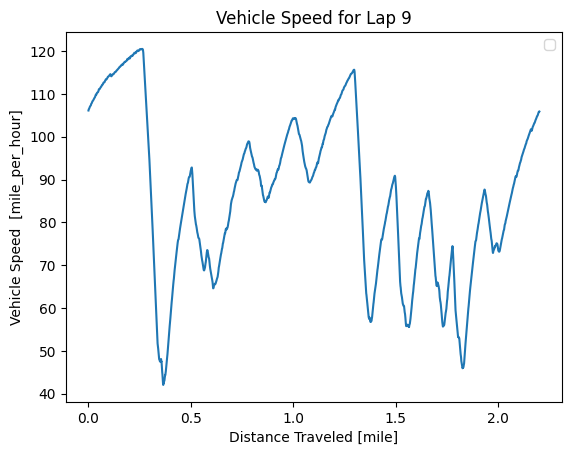

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


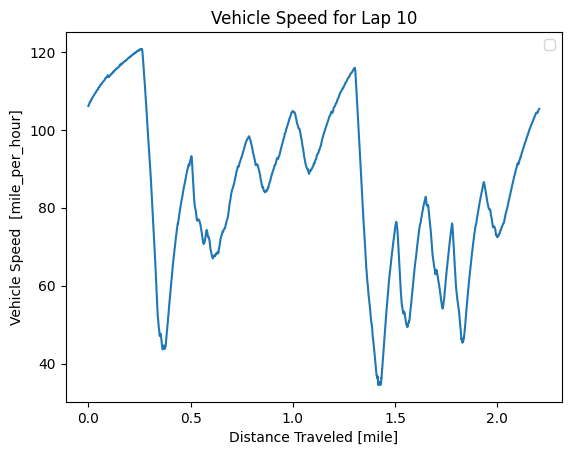

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


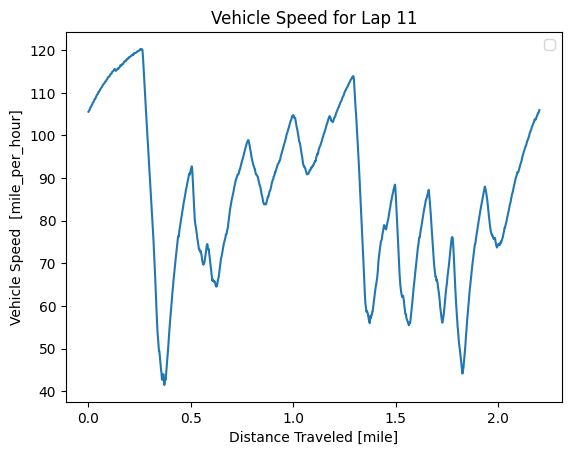

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


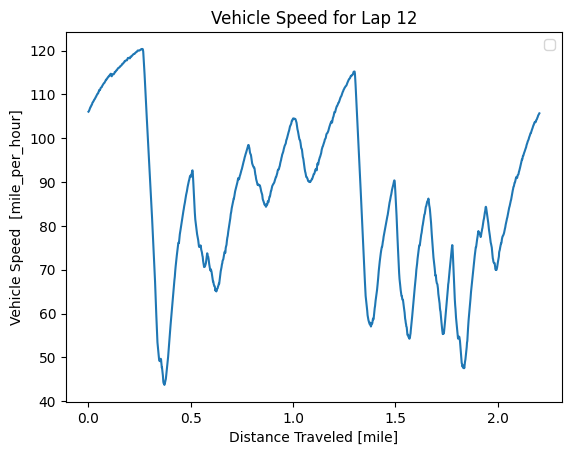

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


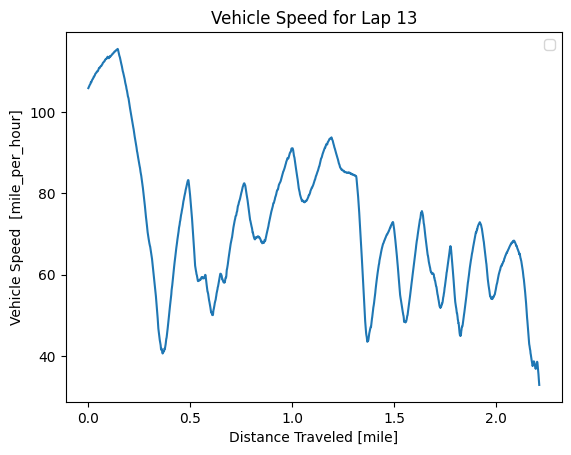

In [19]:
def calculate_cumulative_ke_change_during_braking(group):
    units = str(group['Delta KE'].pint.units)
    cumulative_sum = 0 * u(units)
    cumulative_ke_change = []

    for index, row in group.iterrows():
        if row[COL_BRAKING_ON] == 1:
            cumulative_sum -= row['Delta KE']
        else:
            cumulative_sum = 0 * u(units)
        cumulative_ke_change.append(cumulative_sum)

    return pd.Series(cumulative_ke_change, index=group.index, dtype=f'pint[{units}]')


def regen_calculations(df: pd.DataFrame, data_filepath: str) -> None:
    cumulative_ke_change_during_braking = pd.Series(
        1 * df.groupby(COL_LAP_NUM).apply(
        calculate_cumulative_ke_change_during_braking)
        .reset_index(level=0, drop=True),
        name='Kinetic Energy Recuperated During Braking',
    )

    lap_indices = get_lap_indices(df)
    energy_units = 'kilowatthours'

    plot_map_every_lap(
        df=df,
        data_to_plot=cumulative_ke_change_during_braking,
        data_units=energy_units,
        colorbar_label="Kinetic Energy [Kilowatt Hours]",
        tile_source=MapType.GOOGLE_SATELITE,
        data_filepath=data_filepath,
        show_plots=False,
        save_plots=True,
        # set_custom_colors={0: 'dimgray'},
    )

def plot_simple_cumulative_regen(df, data_filepath):
    energy_units = 'kilowatthours'
    cumulative_ke_change_during_braking = pd.Series(data=(
        df.groupby(COL_LAP_NUM)[[COL_LAP_NUM, 'Delta KE', COL_BRAKING_ON]].apply(
        lambda x: (-1 * x['Delta KE'] * x[COL_BRAKING_ON]).cumsum())),
        name='Cumulative Energy Recuperation During Braking'
    ).reset_index(level=0, drop=True)

    plot_map_every_lap(
        df=df,
        data_to_plot=cumulative_ke_change_during_braking.pint.to(energy_units),
        data_units=energy_units,
        colorbar_label=f'KiloWatt Hours',
        tile_source=MapType.GOOGLE_SATELITE,
        data_filepath=data_filepath,
        save_plots=True,
        show_plots=False,
    )


def plot_simple_for_all_tracks(
        save_plots: bool = True,
        show_plots: bool = False,
    ) -> None:
    save_or_show_plot(save_plots=save_plots, show_plots=show_plots)

    data_files = get_data_files()

    for data_filepath in data_files:
        #### REMOVE LATER ####
        if data_filepath not in RACE_DATA_FILES_TO_USE:
            continue
        ######################
        UNITS: dict[str, str] = {}
        race_data_df = load_race(race_data_filepath=data_filepath, units=UNITS)

        regen_calculations(df=race_data_df, data_filepath=data_filepath)
        generate_simple_speed_plots(df=race_data_df, data_filepath=data_filepath)
        plot_simple_cumulative_regen(df=race_data_df, data_filepath=data_filepath)

        series_to_plot = {
            'GPS Speed': race_data_df['GPS Speed'],
            'GPS BRK On': race_data_df['GPS BRK On'],
            'Front Brake V': race_data_df['Front Brake V'],
            'GPS LatAcc': race_data_df['GPS LatAcc'],
            'GPS LonAcc': race_data_df['GPS LonAcc'],
            # 'ThrottlePercent': race_data_df['ThrottlePercent'],
        }

        names = {
            'GPS Speed': 'Vehicle Speed',
            'GPS BRK On': 'Braking On',
            'Front Brake V': 'Front Braking Voltage',
            'GPS LatAcc': 'Lateral Acceleration',
            'GPS LonAcc': 'Longitudinal Acceleration',
            # 'ThrottlePercent': 'Throttle Percentage',
        }
        for column_name, data_to_plot in series_to_plot.items():
            plot_map_every_lap(
                df=race_data_df,
                data_to_plot=data_to_plot,
                data_units=UNITS[column_name],
                colorbar_label=f'{names[column_name]}  [{data_to_plot.pint.units}]',
                tile_source=MapType.GOOGLE_SATELITE,
                data_filepath=data_filepath,
                save_plots=save_plots,
                show_plots=show_plots,
            )





def generate_simple_speed_plots(df: pd.DataFrame, data_filepath: str):

    #### VEHICLE SPEED FOR EACH LAP VS. DISTANCE ####
    lap_indices = get_lap_indices(df)

    for lap_num in get_usable_lap_nums(data_filepath):
        start_lap_index, end_lap_index = lap_indices[lap_num]

        valid_car_distance = slice_into_df(df['Distance on GPS Speed'], start_lap_index, end_lap_index)
        reset_distances = valid_car_distance - valid_car_distance.iloc[0]
        valid_car_speeds = slice_into_df(df['GPS Speed'], start_lap_index, end_lap_index)
        plt.plot(reset_distances.pint.to('miles'), valid_car_speeds.pint.to('mph'), label=f'Lap {lap_num}')

    plt.xlabel(f'Distance Traveled ({reset_distances.pint.to("miles").pint.units})')
    plt.ylabel(f'Vehicle Speed ({valid_car_speeds.pint.to("mph").pint.units})')
    plt.legend()
    plt.title(f'Vehicle Speed for Each Lap')
    save_plot(data_file=f'{data_filepath}')
    plt.show()
    plt.close()
    #################################################

    #### VEHICLE SPEED FOR EACH LAP VS. DISTANCE ####
    lap_indices = get_lap_indices(df)

    for lap_num in get_usable_lap_nums(data_filepath):
        start_lap_index, end_lap_index = lap_indices[lap_num]

        valid_car_distance = slice_into_df(df['Distance on GPS Speed'], start_lap_index, end_lap_index)
        reset_distances = valid_car_distance - valid_car_distance.iloc[0]
        valid_car_speeds = slice_into_df(df['GPS Speed'], start_lap_index, end_lap_index)
        plt.plot(reset_distances.pint.to('miles'), valid_car_speeds.pint.to('mph'))
        plt.xlabel(f'Distance Traveled [{reset_distances.pint.to("miles").pint.units}]')
        plt.ylabel(f'Vehicle Speed  [{valid_car_speeds.pint.to("mph").pint.units}]')
        plt.legend()
        plt.title(f'Vehicle Speed for Lap {lap_num}')
        save_plot(data_file=f'{data_filepath}', lap_num=lap_num)
        plt.show()
        plt.close()
    #################################################

plot_simple_for_all_tracks()

## Determine Drag Coefficient of the Vehicle

$$F_D = \frac{1}{2}\rho v^2 C_D A$$
where $F_D$ is the drag force, $\rho$ is the density of the fluid (air), $v$ is the speed of the vehicle relative to the fluid, $C_D$ is the drag coefficient, and $A$ is the cross-sectional area of the vehicle.

Rearranged, the coefficient of drag can be determined by:

$$C_D = \frac{2 F_D}{\rho v^2 A}$$

In [ ]:
# def plot_coefficient_of_drag(df: pd.DataFrame, units: dict[str, str]) -> None:

#     #### Drag Calculations ####
#     speed_during_coast = columns_during_state(
#         df=RACE_DATA_DF,
#         data_columns='GPS Speed',
#         state_columns='GPS CST On',
#         append_to_column_name='During Coasting',
#         fill_with_zeros=True,
#     )
#     acceleration_during_coast = columns_during_state(
#         df=RACE_DATA_DF,
#         data_columns='Acceleration',
#         state_columns='GPS CST On',
#         append_to_column_name='During Coasting',
#         fill_with_zeros=True,
#     )

#     drag_force = pd.Series(data=acceleration_during_coast * MASS_VEHICLE, name='Drag Force')
#     drag_coefficient = pd.Series(data=((2*drag_force) / (RHO_AIR * (speed_during_coast**2) * VEHICLE_CROSS_SECTIONAL_AREA)), name='Coefficient of Drag')
#     ###########################

#     legend_values = []
#     lap_indices = get_lap_indices(df)

#     for lap_num in get_usable_lap_nums(RACE_DATA_FILEPATH):
#         start_lap_index, end_lap_index = lap_indices[lap_num]

#         valid_lap_times = slice_into_df(df[COL_TIME], start_lap_index, end_lap_index)
#         valid_drag_coefficients = slice_into_df(drag_coefficient, start_lap_index, end_lap_index)

#         legend_values.append(f'Lap {lap_num}')
#         plt.title(f'Coefficient of Drag')
#         plot_data(valid_lap_times, f'Time ({units[COL_TIME]})', valid_drag_coefficients.pint.to_base_units(), f'Coefficient of Drag ({valid_drag_coefficients.pint.to_base_units().pint.units})')
#         plt.legend(legend_values)
#         # plt.show()

# plot_coefficient_of_drag(df=RACE_DATA_DF, units=UNITS)

# Plotting

In [ ]:
# cumulative_ke_change = pd.Series(data=RACE_DATA_DF.groupby(COL_LAP_NUM)['Delta KE'].apply(lambda x: x.cumsum()))

# abs_cumulative_ke_change_during_coast = pd.Series(data=(
#     RACE_DATA_DF.groupby(COL_LAP_NUM)[[COL_LAP_NUM, 'Delta KE', 'GPS CST On']].apply(
#     lambda x: abs((x['Delta KE'] * x['GPS CST On'])).cumsum())),    # ABS removes pint units from this object
#     name='Absolute Value Cumulative KE Change During Coasting'
# ).reset_index(level=0, drop=True)

# # cumulative_ke_change_during_coast = pd.Series(data=(RACE_DATA_DF * RACE_DATA_DF['GPS CST On']).groupby(COL_LAP_NUM)['Delta KE'].apply(lambda x: x.cumsum()))
# # cumulative_ke_change_during_coast = pd.Series(data=strip_df_of_units(RACE_DATA_DF.groupby(COL_LAP_NUM)['Delta KE']).cumsum(), dtype=f'pint[{UNITS["Delta KE"]}]')

# plt.title(f'Cumulative Change in Kinetic Energy by Lap')
# plot_data(RACE_DATA_DF[COL_TIME], f'Time ({UNITS[COL_TIME]})', abs_cumulative_ke_change_during_coast.pint.to_base_units(), f'Cumulative Change in Kinetic Energy ({abs_cumulative_ke_change_during_coast.pint.to_base_units().pint.units})')

# lap_indices = get_lap_indices(RACE_DATA_DF)

# for lap_num in get_usable_lap_nums(RACE_DATA_FILEPATH):
#     start_lap_index, end_lap_index = lap_indices[lap_num]

#     valid_lap_times = slice_into_df(RACE_DATA_DF[COL_TIME], start_lap_index, end_lap_index)
#     lap_cum_KE = slice_into_df(abs_cumulative_ke_change_during_coast, start_lap_index, end_lap_index)

#     plt.title(f'Cumulative Change in Kinetic Energy for Lap {lap_num}')
#     plot_data(valid_lap_times, f'Time ({UNITS[COL_TIME]})', lap_cum_KE.pint.to_base_units(), f'Cumulative Change in Kinetic Energy ({lap_cum_KE.pint.to_base_units().pint.units})')

## Regenerative Braking Calculations

### Simple Cumulative Change in Kinetic Energy During Braking

data/formatted/BETTER_20230831_143833_Blair Hosie_Rush SR 150_Palmer ACW_a_0045.csv


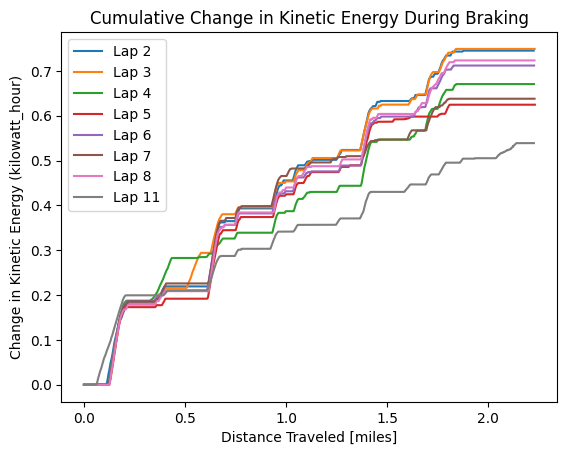

data/formatted/BETTER_20240127_1528_Blair Hosie_Rush SR 0003_PODIUM_Generic testing_a_1215.csv


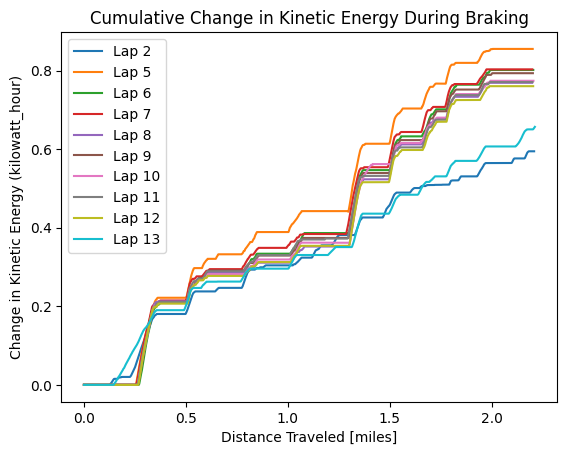

In [17]:
def regen_calculations(df: pd.DataFrame, data_filepath: str) -> None:

    cumulative_ke_change = pd.Series(data=df.groupby(COL_LAP_NUM)['Delta KE'].apply(lambda x: x.cumsum()))

    cumulative_ke_change_during_braking = pd.Series(data=(
        df.groupby(COL_LAP_NUM)[[COL_LAP_NUM, 'Delta KE', COL_BRAKING_ON]].apply(
        lambda x: (-1 * x['Delta KE'] * x[COL_BRAKING_ON]).cumsum())),
        name='Energy Recuperation During Braking'
    ).reset_index(level=0, drop=True)

    lap_indices = get_lap_indices(df)
    energy_units = 'kilowatthours'

    for lap_num in get_usable_lap_nums(data_filepath):
        start_lap_index, end_lap_index = lap_indices[lap_num]

        valid_lap_times = slice_into_df(df[COL_TIME], start_lap_index, end_lap_index)
        zeroed_lap_times = reset_lap_times(valid_lap_times)

        lap_cum_KE = slice_into_df(cumulative_ke_change_during_braking, start_lap_index, end_lap_index)
        valid_car_distance = slice_into_df(df['Distance on GPS Speed'], start_lap_index, end_lap_index)
        reset_distances = valid_car_distance - valid_car_distance.iloc[0]

        # plt.plot(zeroed_lap_times, lap_cum_KE.pint.to(energy_units), label=f'Lap {lap_num}')
        plt.plot(reset_distances.pint.to('miles'), lap_cum_KE.pint.to(energy_units), label=f'Lap {lap_num}')
        # plot_data(zeroed_lap_times, f'Time ({UNITS["Time"]})', reset_distances.pint.to('miles'), f'Vehicle Speed ({valid_car_distance.pint.to("miles").pint.units})')

    plt.xlabel(f'Distance Traveled [miles]')
    # plt.xlabel(f'Time ({UNITS[COL_TIME]})')
    plt.ylabel(f'Change in Kinetic Energy ({lap_cum_KE.pint.to(energy_units).pint.units})')
    plt.legend()
    plt.title(f'Cumulative Change in Kinetic Energy During Braking')
    # save_plot(data_filepath)
    plt.show()


def determine_regen_for_all_data():
    data_files = get_data_files()

    for data_filepath in data_files:
        #### REMOVE LATER ####
        if data_filepath not in RACE_DATA_FILES_TO_USE:
            continue
        ######################
        print(data_filepath)
        UNITS: dict[str, str] = {}
        race_data_df = load_race(race_data_filepath=data_filepath, units=UNITS)

        regen_calculations(race_data_df, data_filepath)

determine_regen_for_all_data()

# regen_calculations(RACE_DATA_DF, RACE_DATA_FILEPATH)

### Cumulative Change in KE During Braking Each Brake-Cycle

In [ ]:
def calculate_cumulative_ke_change_during_braking(group):
    units = str(group['Delta KE'].pint.units)
    cumulative_sum = 0 * u(units)
    cumulative_ke_change = []

    for index, row in group.iterrows():
        if row[COL_BRAKING_ON] == 1:
            cumulative_sum += row['Delta KE']
        else:
            cumulative_sum = 0 * u(units)
        cumulative_ke_change.append(cumulative_sum)

    return pd.Series(cumulative_ke_change, index=group.index, dtype=f'pint[{units}]')


def regen_calculations(df: pd.DataFrame, data_filepath: str) -> None:
    cumulative_ke_change_during_braking = pd.Series(
        -1 * df.groupby(COL_LAP_NUM).apply(
        calculate_cumulative_ke_change_during_braking)
        .reset_index(level=0, drop=True),
        name='Cumulative KE Change During Braking',
    )

    lap_indices = get_lap_indices(df)
    energy_units = 'kilowatthours'

    plot_map_every_lap(
        df=RACE_DATA_DF,
        data_to_plot=cumulative_ke_change_during_braking,
        data_units=energy_units,
        colorbar_label="Kinetic Energy [Kilowatt Hours]",
        tile_source=MapType.GOOGLE_SATELITE,
        data_filepath=RACE_DATA_FILEPATH,
        show_plots=True,
        save_plots=False,
    )



def determine_regen_for_all_data():
    data_files = get_data_files()

    for data_filepath in data_files:
        #### REMOVE LATER ####
        if data_filepath not in RACE_DATA_FILES_TO_USE:
            continue
        ######################
        print(data_filepath)
        UNITS: dict[str, str] = {}
        race_data_df = load_race(race_data_filepath=data_filepath, units=UNITS)

        regen_calculations(race_data_df, data_filepath)

determine_regen_for_all_data()
# regen_calculations(RACE_DATA_DF, RACE_DATA_FILEPATH)



## Actual Graphs

### Cumulative Regen

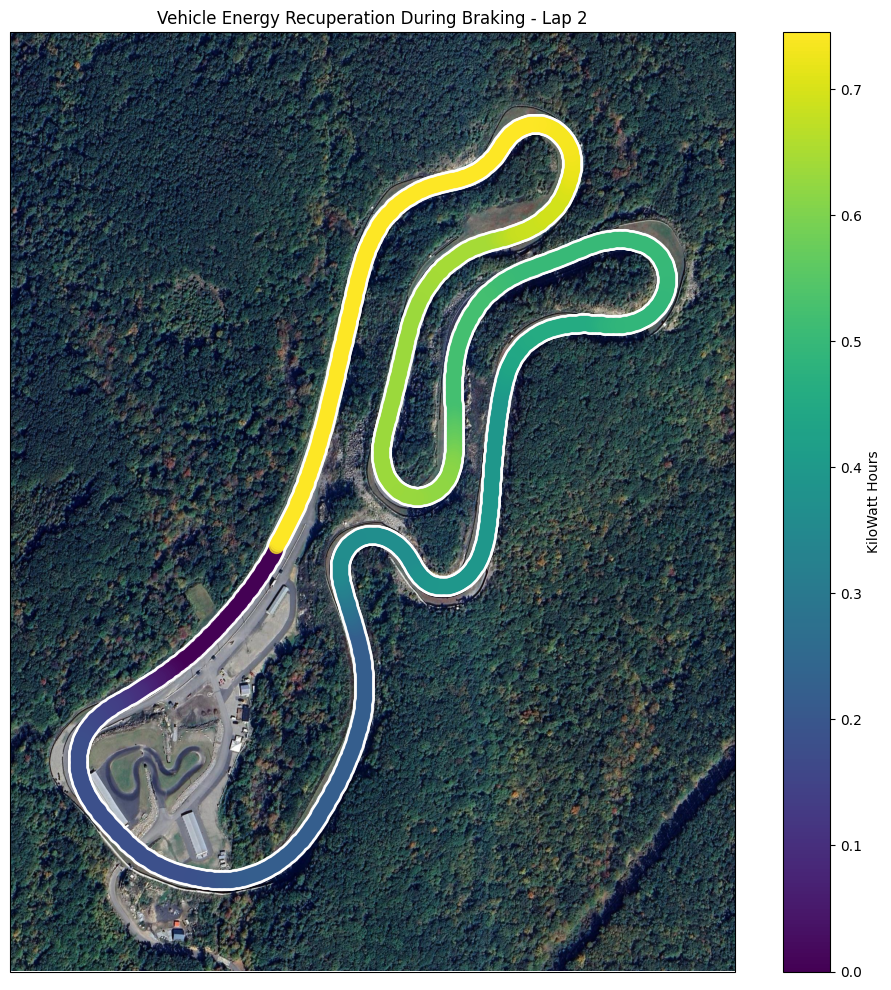

KeyboardInterrupt: 

In [18]:
def plot_cumulative_regen_all_tracks(
        save_plots: bool = False,
        show_plots: bool = True,
    ) -> None:
    save_or_show_plot(save_plots=save_plots, show_plots=show_plots)

    data_files = get_data_files()

    for data_filepath in data_files:
        #### REMOVE LATER ####
        if data_filepath not in RACE_DATA_FILES_TO_USE:
            continue
        ######################

        UNITS: dict[str, str] = {}
        race_data_df = load_race(race_data_filepath=data_filepath, units=UNITS)

        energy_units = 'kilowatthours'
        cumulative_ke_change_during_braking = pd.Series(data=(
            race_data_df.groupby(COL_LAP_NUM)[[COL_LAP_NUM, 'Delta KE', COL_BRAKING_ON]].apply(
            lambda x: (-1 * x['Delta KE'] * x[COL_BRAKING_ON]).cumsum())),
            name='Energy Recuperation During Braking'
        ).reset_index(level=0, drop=True)

        plot_map_every_lap(
            df=race_data_df,
            data_to_plot=cumulative_ke_change_during_braking.pint.to(energy_units),
            data_units=energy_units,
            colorbar_label=f'KiloWatt Hours',
            tile_source=MapType.GOOGLE_SATELITE,
            data_filepath=data_filepath,
            save_plots=save_plots,
            show_plots=show_plots,
        )

plot_cumulative_regen_all_tracks()

### Parameters During Braking

In [ ]:
def plot_all_columns_during_braking(
        df: pd.DataFrame,
        data_filepath: str,
        save_plots: bool = True,
        show_plots: bool = False,
    ) -> None:
    save_or_show_plot(save_plots=save_plots, show_plots=show_plots)

    for data_column in df.columns:
        data_during_braking = columns_during_state(
            df=df,
            data_columns=data_column,
            state_columns=COL_BRAKING_ON,
            append_to_column_name='During Braking',
            fill_with_zeros=True,
        )
        data_during_braking = pd.Series(data=(
            df.groupby(COL_LAP_NUM)[[COL_LAP_NUM, 'Delta KE', COL_BRAKING_ON]].apply(
            lambda x: (x['Delta KE'] * x[COL_BRAKING_ON]).cumsum())),
            name='Energy Recuperation During Braking'
        ).reset_index(level=0, drop=True).pint.to_base_units()

        data_units = data_during_braking.pint.units
        plot_map(
            df=df,
            data_to_plot=data_during_braking.pint.to_base_units(),
            data_units=data_during_braking.pint.units,
            lap_num=3,
            colorbar_label=f'{str(df[data_column].pint.dimensionality).capitalize()} ({data_units})',
            tile_source=MapType.GOOGLE_SATELITE,
            data_filepath=data_filepath,
            save_plots=save_plots,
            show_plots=show_plots,
        )

plot_all_columns_during_braking(RACE_DATA_DF, RACE_DATA_FILEPATH)

In [ ]:
# cumulative_ke_change = pd.Series(data=RACE_DATA_DF.groupby(COL_LAP_NUM)['Delta KE'].apply(lambda x: x.cumsum()))

# cumulative_ke_change_during_braking = pd.Series(data=(
#     RACE_DATA_DF.groupby(COL_LAP_NUM)[[COL_LAP_NUM, 'Delta KE', COL_BRAKING_ON]].apply(
#     lambda x: abs((x['Delta KE'] * x[COL_BRAKING_ON])).cumsum())),
#     name='Cumulative KE Change During Braking'
# ).reset_index(level=0, drop=True)

# # abs_cumulative_ke_change_during_braking = pd.Series(data=(
# #     RACE_DATA_DF.groupby(COL_LAP_NUM)[[COL_LAP_NUM, 'Delta KE', COL_BRAKING_ON]].apply(
# #     lambda x: abs((x['Delta KE'] * x[COL_BRAKING_ON])).cumsum())),
# #     name='Absolute Value Cumulative KE Change During Braking'
# # ).reset_index(level=0, drop=True)

# # cumulative_ke_change_during_coast = pd.Series(data=(RACE_DATA_DF * RACE_DATA_DF['GPS CST On']).groupby(COL_LAP_NUM)['Delta KE'].apply(lambda x: x.cumsum()))
# # cumulative_ke_change_during_coast = pd.Series(data=strip_df_of_units(RACE_DATA_DF.groupby(COL_LAP_NUM)['Delta KE']).cumsum(), dtype=f'pint[{UNITS["Delta KE"]}]')

# plt.title(f'Cumulative Change in Kinetic Energy by Lap')
# plot_data(RACE_DATA_DF[COL_TIME], f'Time ({UNITS[COL_TIME]})', abs_cumulative_ke_change_during_braking.pint.to_base_units(), f'Cumulative Change in Kinetic Energy ({abs_cumulative_ke_change_during_coast.pint.to_base_units().pint.units})')

# lap_indices = get_lap_indices(RACE_DATA_DF)

# for lap_num in get_usable_lap_nums(RACE_DATA_FILEPATH):
#     start_lap_index, end_lap_index = lap_indices[lap_num]

#     valid_lap_times = slice_into_df(RACE_DATA_DF[COL_TIME], start_lap_index, end_lap_index)
#     lap_cum_KE = slice_into_df(abs_cumulative_ke_change_during_braking, start_lap_index, end_lap_index)

#     plt.title(f'Cumulative Change in Kinetic Energy During Braking for Lap {lap_num}')
#     plot_data(
#         valid_lap_times,
#         f'Time ({UNITS[COL_TIME]})',
#         lap_cum_KE.pint.to_base_units(),
#         f'Cumulative Change in Kinetic Energy ({lap_cum_KE.pint.to_base_units().pint.units})'
#     )

In [ ]:
#### VEHICLE SPEED FOR EACH LAP VS. TIME ####
# lap_indices = get_lap_indices(RACE_DATA_DF)

# for lap_num in get_usable_lap_nums(RACE_DATA_FILEPATH):
#     start_lap_index, end_lap_index = lap_indices[lap_num]

#     valid_lap_times = slice_into_df(RACE_DATA_DF['Time'], start_lap_index, end_lap_index)
#     zeroed_lap_times = np.linspace(0, valid_lap_times.iloc[-1] - valid_lap_times.iloc[0], len(valid_lap_times))
#     valid_car_speeds = slice_into_df(RACE_DATA_DF['GPS Speed'], start_lap_index, end_lap_index)
#     plt.plot(zeroed_lap_times, valid_car_speeds.pint.to('mph'), label=f'Lap {lap_num}')
#     # plot_data(zeroed_lap_times, f'Time ({UNITS["Time"]})', valid_car_speeds.pint.to('mph'), f'Vehicle Speed ({valid_car_speeds.pint.to("mph").pint.units})')

# plt.xlabel(f'Time ({UNITS["Time"]})')
# plt.ylabel(f'Vehicle Speed ({valid_car_speeds.pint.to("mph").pint.units})')
# plt.legend()
# plt.title(f'Vehicle Speed for Each Lap')
# plt.show()
#############################################


#### VEHICLE SPEED FOR EACH LAP VS. DISTANCE ####
lap_indices = get_lap_indices(RACE_DATA_DF)

for lap_num in get_usable_lap_nums(RACE_DATA_FILEPATH):
    start_lap_index, end_lap_index = lap_indices[lap_num]

    valid_car_distance = slice_into_df(RACE_DATA_DF['Distance on GPS Speed'], start_lap_index, end_lap_index)
    reset_distances = valid_car_distance - valid_car_distance.iloc[0]
    valid_car_speeds = slice_into_df(RACE_DATA_DF['GPS Speed'], start_lap_index, end_lap_index)
    plt.plot(reset_distances.pint.to('miles'), valid_car_speeds.pint.to('mph'), label=f'Lap {lap_num}')

plt.xlabel(f'Distance Traveled ({reset_distances.pint.to("miles").pint.units})')
plt.ylabel(f'Vehicle Speed ({valid_car_speeds.pint.to("mph").pint.units})')
plt.legend()
plt.title(f'Vehicle Speed at Specific Point for Each Lap')
save_plot(data_file=RACE_DATA_FILEPATH)
plt.show()
#################################################


lap_indices = get_lap_indices(RACE_DATA_DF)

for lap_num in get_usable_lap_nums(RACE_DATA_FILEPATH):
    start_lap_index, end_lap_index = lap_indices[lap_num]

    valid_lap_times = slice_into_df(RACE_DATA_DF['Time'], start_lap_index, end_lap_index)
    zeroed_lap_times = np.linspace(0, valid_lap_times.iloc[-1] - valid_lap_times.iloc[0], len(valid_lap_times))
    valid_car_distance = slice_into_df(RACE_DATA_DF['Distance on GPS Speed'], start_lap_index, end_lap_index)
    reset_distances = valid_car_distance - valid_car_distance.iloc[0]
    plt.plot(zeroed_lap_times, reset_distances.pint.to('miles'), label=f'Lap {lap_num}')
    # plot_data(zeroed_lap_times, f'Time ({UNITS["Time"]})', reset_distances.pint.to('miles'), f'Vehicle Speed ({valid_car_distance.pint.to("miles").pint.units})')

plt.legend()
plt.xlabel(f'Time ({UNITS["Time"]})')
plt.ylabel(f'Distance Traveled ({reset_distances.pint.to("miles").pint.units})')
plt.title(f'Distance Traveled for Each Lap')
plt.show()

In [ ]:
lap_indices = get_lap_indices(RACE_DATA_DF)

for lap_num in get_usable_lap_nums(RACE_DATA_FILEPATH):
    start_lap_index, end_lap_index = lap_indices[lap_num]

    valid_lap_times = slice_into_df(RACE_DATA_DF['Time'], start_lap_index, end_lap_index)
    zeroed_lap_times = np.linspace(0, valid_lap_times.iloc[-1] - valid_lap_times.iloc[0], len(valid_lap_times))
    valid_car_distance = slice_into_df(RACE_DATA_DF['Distance on GPS Speed'], start_lap_index, end_lap_index)
    reset_distances = valid_car_distance - valid_car_distance.iloc[0]
    plt.plot(zeroed_lap_times, reset_distances.pint.to('miles'), label=f'Lap {lap_num}')
    # plot_data(zeroed_lap_times, f'Time ({UNITS["Time"]})', reset_distances.pint.to('miles'), f'Vehicle Speed ({valid_car_distance.pint.to("miles").pint.units})')

plt.legend()
plt.xlabel(f'Time ({UNITS[COL_TIME]})')
plt.ylabel(f'Distance Traveled ({reset_distances.pint.to("miles").pint.units})')
plt.title(f'Distance Traveled for Each Lap')
plt.show()

## Maps

In [ ]:
from race_analysis.map_data import plot_map_every_lap

### Plot GPS Speed

In [ ]:
def plot_GPS_Speed(
        df: pd.DataFrame,
        data_filepath: Optional[str] = None,
        save_plots: bool = True,
        show_plots: bool = False,
    ) -> None:
    save_or_show_plot(save_plots=save_plots, show_plots=show_plots)

    data_name = 'GPS Speed'
    plot_units = 'mph'
    colorbar_label = f'Velocity [{plot_units}]'
    data_filepath = data_filepath if data_filepath is not None else RACE_DATA_FILEPATH

    plot_map_every_lap(
        df=df,
        data_to_plot=df[data_name],
        data_units=plot_units,
        colorbar_label=colorbar_label,
        tile_source=MapType.GOOGLE_SATELITE,
        data_filepath=data_filepath,
        save_plots=save_plots,
        show_plots=show_plots,
    )

    if save_plots:
        save_plot(data_filepath)

# plot_GPS_Speed(df=RACE_DATA_DF)

In [ ]:
def plot_GPS_G_Sum(
        df: pd.DataFrame,
        data_filepath: Optional[str] = None,
        save_plots: bool = True,
        show_plots: bool = False,
    ) -> None:
    save_or_show_plot(save_plots=save_plots, show_plots=show_plots)

    data_name = 'GPS G Sum'
    data_filepath = data_filepath if data_filepath is not None else RACE_DATA_FILEPATH

    plot_map_every_lap(
        df=df,
        data_to_plot=df[data_name],
        data_units=(u.m/(u.s**2)),
        colorbar_label='Acceleration (m/s^2)',
        tile_source=MapType.GOOGLE_SATELITE,
        data_filepath=data_filepath,
        save_plots=save_plots,
        show_plots=show_plots,
    )
    save_plot(data_filepath)

# plot_GPS_G_Sum(df=RACE_DATA_DF)

In [ ]:
def plot_Acceleration(
        df: pd.DataFrame,
        data_filepath: Optional[str] = None,
        save_plots: bool = True,
        show_plots: bool = False,
    ) -> None:
    save_or_show_plot(save_plots=save_plots, show_plots=show_plots)

    data_name = 'Acceleration'
    colorbar_label = 'Acceleration [m/(s^2)]'
    data_filepath = data_filepath if data_filepath is not None else RACE_DATA_FILEPATH

    plot_map_every_lap(
        df=df,
        data_to_plot=df[data_name],
        data_units=(u.m/(u.s**2)),
        colorbar_label=colorbar_label,
        tile_source=MapType.GOOGLE_SATELITE,
        data_filepath=data_filepath,
        save_plots=save_plots,
        show_plots=show_plots,
    )

# plot_Acceleration(df=RACE_DATA_DF)

In [ ]:
def plot_column_for_all_tracks(
        column_name: str,
        save_plots: bool = True,
        show_plots: bool = False,
    ) -> None:
    save_or_show_plot(save_plots=save_plots, show_plots=show_plots)

    data_files = get_data_files()

    for data_filepath in data_files:
        #### REMOVE LATER ####
        if data_filepath not in RACE_DATA_FILES_TO_USE:
            continue
        ######################
        UNITS: dict[str, str] = {}
        race_data_df = load_race(race_data_filepath=data_filepath, units=UNITS)
        plot_map_every_lap(
            df=race_data_df,
            data_to_plot=race_data_df[column_name],
            colorbar_label=f'{race_data_df[column_name].pint.units}',
            tile_source=MapType.GOOGLE_SATELITE,
            data_filepath=data_filepath,
            save_plots=save_plots,
            show_plots=show_plots,
        )

# plot_column_for_all_tracks(df=RACE_DATA_DF, column_name='GPS Speed')

In [ ]:
def plot_all_columns(
        df: pd.DataFrame,
        data_filepath: Optional[str] = None,
        save_plots: bool = True,
        show_plots: bool = False,
    ) -> None:
    save_or_show_plot(save_plots=save_plots, show_plots=show_plots)

    data_filepath = data_filepath if data_filepath is not None else RACE_DATA_FILEPATH

    for data_column in df.columns:
        try:
            print(f'\tPLOTTING COLUMN:      \t{data_column}')
            data_units = df[data_column].pint.units
            plot_map_every_lap(
                df=df,
                data_to_plot=df[data_column],
                data_units=data_units,
                colorbar_label=f'{str(df[data_column].pint.dimensionality).capitalize()} ({data_units})',
                tile_source=MapType.GOOGLE_SATELITE,
                data_filepath=data_filepath,
                save_plots=save_plots,
                show_plots=show_plots,
            )
        except Exception as error:
            print(f'\tFAILED TO PLOT COLUMN:\t{data_column}')
            print(f'\t{error}')

# plot_all_columns(df=RACE_DATA_DF)

In [ ]:
def plot_all_columns_for_all_tracks(
        save_plots: bool = True,
        show_plots: bool = False,
    ) -> None:
    save_or_show_plot(save_plots=save_plots, show_plots=show_plots)

    data_files = get_data_files()

    for data_filepath in data_files:
        #### REMOVE LATER ####
        if data_filepath not in RACE_DATA_FILES_TO_USE:
            continue
        ######################
        print(f'PLOTTING\t{get_filename(data_filepath)}')
        UNITS = {}
        race_data_df = load_race(race_data_filepath=data_filepath, units=UNITS)
        plot_all_columns(
            df=race_data_df,
            data_filepath=data_filepath,
            save_plots=save_plots,
            show_plots=show_plots,
        )

plot_all_columns_for_all_tracks()